## HOMEWORK 3  
#### Convolutional Neural Networks

In [1]:
import torch, torchvision
from torchvision.transforms import v2
from torch import nn

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

#### Import and Load CIFAR10 Dataset

In [2]:
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)


/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [3]:
print(training_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /lus/eagle/projects/datasets/CIFAR-10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToTensor()
                 RandomHorizontalFlip(p=0.5)
                 RandomResizedCrop(size=(32, 32), scale=[0.85, 1.0], ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=False)
                 ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2))
           )


### Split Training Data into Training and Validation

In [4]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [5]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)

val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

### Visualize Data

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

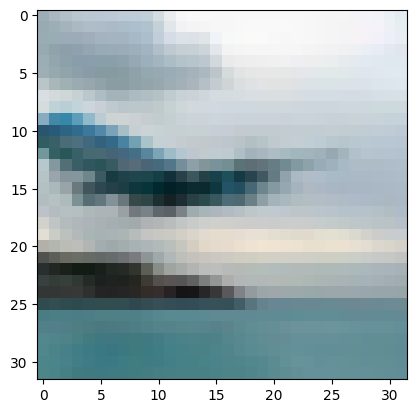

In [7]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

### Send data to GPU

In [8]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

### Downsampler

In [9]:
class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))

### Convolution Block

In [10]:
class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs

### Classifier NN

In [11]:
class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x

In [12]:
model = Classifier(32, 2, 4)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 64, 16, 16]         --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [13]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [14]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.004)

In [16]:
from tqdm.notebook import tqdm


epochs = 50
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.593, accuracy: 41.539


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.587, accuracy: 41.555


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.357, accuracy: 51.435


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.359, accuracy: 50.969


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.245, accuracy: 55.901


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.267, accuracy: 54.460


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.054, accuracy: 62.687


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.077, accuracy: 61.472


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.012, accuracy: 64.622


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.045, accuracy: 63.044


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.892, accuracy: 68.802


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.938, accuracy: 66.386


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.805, accuracy: 72.027


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.856, accuracy: 69.600


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.708, accuracy: 75.467


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.769, accuracy: 73.062


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.647, accuracy: 77.528


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.722, accuracy: 74.614


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.600, accuracy: 79.248


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.694, accuracy: 75.455


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.594, accuracy: 79.141


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.685, accuracy: 75.574


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.551, accuracy: 80.678


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.664, accuracy: 76.365


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.506, accuracy: 82.159


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.633, accuracy: 77.769


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.498, accuracy: 82.832


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.629, accuracy: 77.838


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.458, accuracy: 84.110


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.608, accuracy: 78.402


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.511, accuracy: 82.441


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.682, accuracy: 76.365


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.399, accuracy: 86.282


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.573, accuracy: 80.142


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.387, accuracy: 86.646


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.559, accuracy: 80.073


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.387, accuracy: 86.604


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.582, accuracy: 79.767


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.353, accuracy: 87.605


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.579, accuracy: 79.895


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.328, accuracy: 88.493


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.554, accuracy: 80.706


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.344, accuracy: 87.884


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.571, accuracy: 80.291


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.295, accuracy: 89.839


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.534, accuracy: 81.576


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.299, accuracy: 89.424


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.553, accuracy: 81.141


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.279, accuracy: 90.218


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.555, accuracy: 81.032


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.272, accuracy: 90.408


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.560, accuracy: 80.943


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.258, accuracy: 90.772


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.551, accuracy: 81.349


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.238, accuracy: 91.686


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.535, accuracy: 82.061


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.240, accuracy: 91.499


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.579, accuracy: 81.003


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.215, accuracy: 92.532


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.563, accuracy: 81.715


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 0.197, accuracy: 93.109


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.542, accuracy: 81.972


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31: training loss: 0.242, accuracy: 91.266


Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.626, accuracy: 80.558


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32: training loss: 0.183, accuracy: 93.600


Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.554, accuracy: 82.308


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33: training loss: 0.203, accuracy: 92.904


Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.575, accuracy: 81.843


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34: training loss: 0.205, accuracy: 92.732


Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.613, accuracy: 80.528


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 0.184, accuracy: 93.438


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.579, accuracy: 82.180


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36: training loss: 0.177, accuracy: 93.558


Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.618, accuracy: 81.636


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37: training loss: 0.162, accuracy: 94.267


Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.583, accuracy: 82.259


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38: training loss: 0.137, accuracy: 95.148


Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.572, accuracy: 82.803


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39: training loss: 0.148, accuracy: 94.786


Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.600, accuracy: 82.091


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 0.139, accuracy: 94.936


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 0.597, accuracy: 82.051


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41: training loss: 0.153, accuracy: 94.391


Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 0.635, accuracy: 81.853


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42: training loss: 0.140, accuracy: 95.040


Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 0.618, accuracy: 82.644


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43: training loss: 0.140, accuracy: 94.908


Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 0.627, accuracy: 82.496


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44: training loss: 0.121, accuracy: 95.602


Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 0.615, accuracy: 82.011


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 0.122, accuracy: 95.550


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 0.635, accuracy: 82.486


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46: training loss: 0.115, accuracy: 95.797


Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 0.622, accuracy: 82.180


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47: training loss: 0.138, accuracy: 94.968


Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 0.662, accuracy: 81.883


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48: training loss: 0.106, accuracy: 96.261


Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 0.636, accuracy: 82.239


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49: training loss: 0.116, accuracy: 95.779


Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 0.658, accuracy: 82.536


## Comment

### I played with several components for the network. To reduce overfitting, my intuition is that we either reduce the number of parameters or we increase the weight decay, which affects the regularization of the network. The CNN before had over 7 million parameters, and now I have less than 1 million. Because I reduce the number of parameters significantly, I also needed to adjust the learning rate and the weight decay. Also, I am not sure if this is correct, but my intution is that having more convolutions before downsampling helps perserve features, but too many becomes "too encoded". Finally, while I do realize it converged close to the 30th epoch, I ran a lot more just out of curiosity. 